w: [0.51514677 0.40859862]
b: 0.41919988813057485


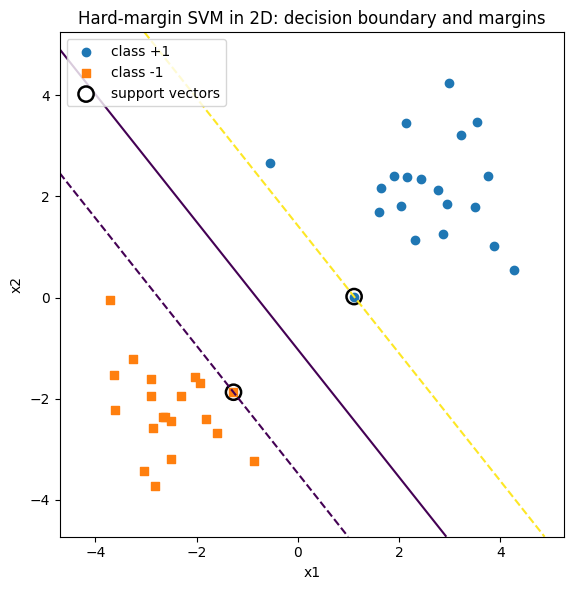

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

np.random.seed(0)

X_pos = np.random.randn(20, 2) + np.array([2, 2])
y_pos = np.ones(20)

X_neg = np.random.randn(20, 2) + np.array([-2, -2])
y_neg = -np.ones(20)

X = np.vstack([X_pos, X_neg])
y = np.hstack([y_pos, y_neg])

clf = SVC(kernel="linear", C=1e6)
clf.fit(X, y)

w = clf.coef_[0]
b = clf.intercept_[0]

print("w:", w)
print("b:", b)

# 3) تعریف تابع f(x) = w^T x + b برای رسم مرزها
def decision_function(x1, x2):
    return w[0] * x1 + w[1] * x2 + b

# 4) ساختن مش‌بندی برای رسم کانتورهای 0 و ±1
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 500),
    np.linspace(y_min, y_max, 500)
)
Z = decision_function(xx, yy)

# 5) رسم
plt.figure(figsize=(6, 6))

# نقاط دو کلاس
plt.scatter(X_pos[:, 0], X_pos[:, 1], marker="o", label="class +1")
plt.scatter(X_neg[:, 0], X_neg[:, 1], marker="s", label="class -1")

# مرز تصمیم: w^T x + b = 0
cs0 = plt.contour(xx, yy, Z, levels=[0], linestyles=["-"])
# حاشیه‌ها: w^T x + b = ±1
cs1 = plt.contour(xx, yy, Z, levels=[-1, 1], linestyles=["--"])

# بردارهای پشتیبان
sv = clf.support_vectors_
plt.scatter(sv[:, 0], sv[:, 1],
            s=120, facecolors="none",
            edgecolors="k", linewidths=1.8,
            label="support vectors")

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Hard-margin SVM in 2D: decision boundary and margins")
plt.legend()
plt.gca().set_aspect("equal", adjustable="box")
plt.tight_layout()
plt.show()


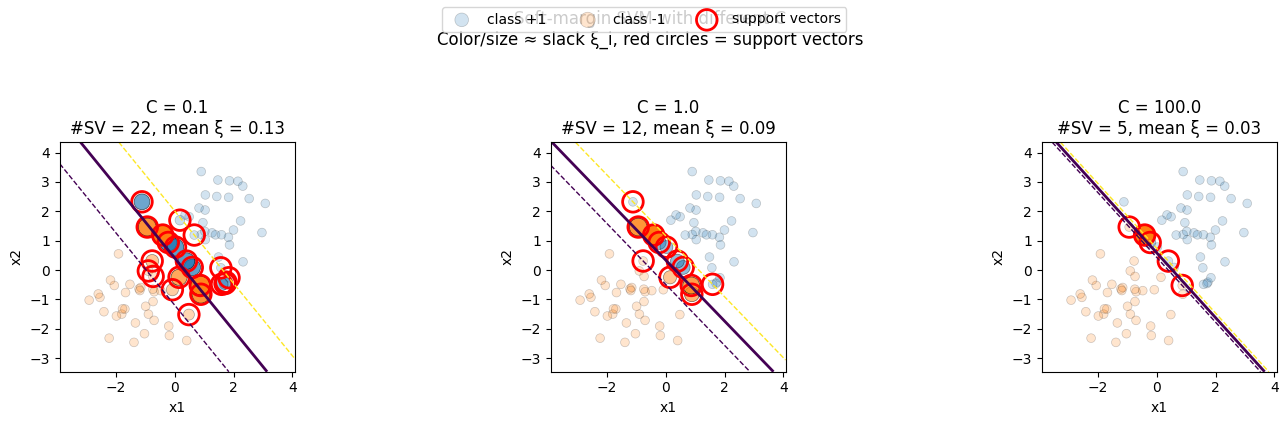

Figure saved as SoftMargin_C_demo.jpg


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# -------------------------------
# 1) ساخت دیتای دوبعدی غیر جداشدنی
# -------------------------------
np.random.seed(42)

# کلاس +1
X_pos = np.random.randn(40, 2) + np.array([1.5, 1.5])
y_pos = np.ones(40)

# کلاس -1
X_neg = np.random.randn(40, 2) + np.array([-1.0, -1.0])
y_neg = -np.ones(40)

X = np.vstack([X_pos, X_neg])
y = np.hstack([y_pos, y_neg])

# -------------------------------
# 2) مقادیر مختلف C
# -------------------------------
C_values = [0.1, 1.0, 100.0]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, C in zip(axes, C_values):
    # --------------------------------
    # 2-1) آموزش SVM نرم‌حاشیه خطی
    # --------------------------------
    clf = SVC(kernel="linear", C=C)
    clf.fit(X, y)

    w = clf.coef_[0]
    b = clf.intercept_[0]

    # --------------------------------
    # 2-2) محاسبه‌ی f(x_i) و slack ها
    #     xi_i = max(0, 1 - y_i f(x_i))
    # --------------------------------
    f_vals = clf.decision_function(X)        # f(x_i) = w^T x_i + b
    slacks = np.maximum(0, 1 - y * f_vals)   # ξ_i

    # تعداد بردارهای پشتیبان و میانگین نقض حاشیه
    n_sv = len(clf.support_vectors_)
    mean_slack = slacks.mean()

    # --------------------------------
    # 2-3) آماده‌سازی مش‌بندی برای رسم مرز تصمیم
    # --------------------------------
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 400),
        np.linspace(y_min, y_max, 400)
    )
    Z = (w[0] * xx + w[1] * yy + b)  # decision function روی گرید

    # --------------------------------
    # 2-4) رسم مرز تصمیم و حاشیه‌ها
    # --------------------------------
    # مرز تصمیم: f(x) = 0
    ax.contour(xx, yy, Z, levels=[0], linestyles=["-"], linewidths=2)

    # حاشیه‌ها: f(x) = ±1
    ax.contour(xx, yy, Z, levels=[-1, 1], linestyles=["--"], linewidths=1)

    # --------------------------------
    # 2-5) رسم نقاط با رنگ/سایز وابسته به slack
    # --------------------------------
    # برای ویژوال بهتر، slack را نرمالیزه می‌کنیم
    if slacks.max() > 0:
        slack_norm = slacks / slacks.max()
    else:
        slack_norm = slacks

    # سایز نقطه‌ها تابع slack
    sizes = 40 + 160 * slack_norm   # مینیمم 40، ماکزیمم 200

    # رنگ: آبی برای y=+1، نارنجی برای y=-1
    # ولی شفافیت تابع slack (هرچی slack بیشتر، نقطه پررنگ‌تر)
    alpha_vals = 0.2 + 0.8 * slack_norm  # بین 0.2 تا 1.0

    for cls, color, label in [(1, "tab:blue", "class +1"),
                              (-1, "tab:orange", "class -1")]:
        mask = (y == cls)
        ax.scatter(
            X[mask, 0],
            X[mask, 1],
            c=color,
            s=sizes[mask],
            alpha=alpha_vals[mask],
            edgecolors="k",
            linewidths=0.5,
            label=label if C == C_values[0] else None  # فقط بار اول در legend
        )

    # بردارهای پشتیبان را با دایره‌ی توخالی نشان می‌دهیم
    sv = clf.support_vectors_
    ax.scatter(
        sv[:, 0], sv[:, 1],
        s=220,
        facecolors="none",
        edgecolors="red",
        linewidths=2,
        label="support vectors" if C == C_values[0] else None
    )

    ax.set_title(f"C = {C}\n#SV = {n_sv}, mean ξ = {mean_slack:.2f}")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_aspect("equal", adjustable="box")

# یک legend مشترک
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3)

fig.suptitle("Soft-margin SVM with different C\nColor/size ≈ slack ξ_i, red circles = support vectors",
             fontsize=12, y=1.05)

plt.tight_layout()
plt.savefig("SoftMargin_C_demo.jpg", dpi=300, bbox_inches="tight")
plt.show()

print("Figure saved as SoftMargin_C_demo.jpg")


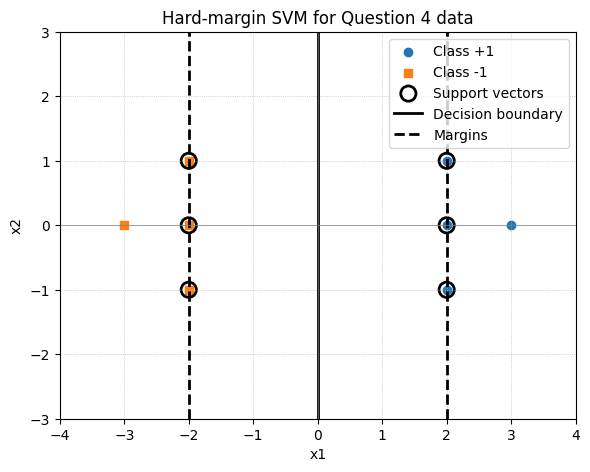

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Data from Question 4
# -----------------------------
# Positive class
X_pos = np.array([
    [2, 0],
    [3, 0],
    [2, 1],
    [2, -1]
])

# Negative class
X_neg = np.array([
    [-2, 0],
    [-3, 0],
    [-2, -1],
    [-2, 1]
])

# Stack for convenience (if needed)
X = np.vstack([X_pos, X_neg])
y = np.hstack([np.ones(len(X_pos)), -np.ones(len(X_neg))])

# -----------------------------
# SVM solution from hand derivation
# -----------------------------
w = np.array([0.5, 0.0])  # (1/2, 0)
b = 0.0                   # bias

# Decision boundary: w^T x + b = 0  ->  x1 = 0
# Margins: w^T x + b = ±1 -> x1 = ±2

# For plotting vertical lines, we just choose a y-range
y_min, y_max = -3, 3

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(6, 6))

# Plot points
plt.scatter(X_pos[:, 0], X_pos[:, 1], marker='o', label='Class +1')
plt.scatter(X_neg[:, 0], X_neg[:, 1], marker='s', label='Class -1')

# Support vectors: points with x1 = ±2
sv_mask = (np.isclose(X[:, 0], 2.0) | np.isclose(X[:, 0], -2.0))
SV = X[sv_mask]

plt.scatter(SV[:, 0], SV[:, 1],
            facecolors='none', edgecolors='k',
            s=120, linewidths=2, label='Support vectors')

# Decision boundary x1 = 0
plt.plot([0, 0], [y_min, y_max], 'k-', linewidth=2, label='Decision boundary')

# Margins x1 = 2 and x1 = -2
plt.plot([2, 2], [y_min, y_max], 'k--', linewidth=2, label='Margins')
plt.plot([-2, -2], [y_min, y_max], 'k--', linewidth=2)

# Formatting
plt.xlim(-4, 4)
plt.ylim(y_min, y_max)
plt.axhline(0, color='gray', linewidth=0.5)  # x2-axis
plt.axvline(0, color='gray', linewidth=0.5)  # x1-axis

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Hard-margin SVM for Question 4 data')
plt.legend(loc='upper right')
plt.gca().set_aspect('equal', 'box')

plt.grid(True, linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()


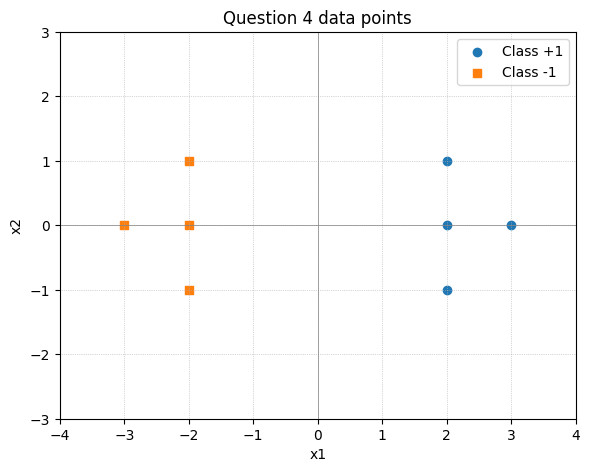

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Data from Question 4
# -----------------------------
# Positive class
X_pos = np.array([
    [2, 0],
    [3, 0],
    [2, 1],
    [2, -1]
])

# Negative class
X_neg = np.array([
    [-2, 0],
    [-3, 0],
    [-2, -1],
    [-2, 1]
])

# -----------------------------
# Scatter plot of the points
# -----------------------------
plt.figure(figsize=(6, 6))

plt.scatter(X_pos[:, 0], X_pos[:, 1], marker='o', label='Class +1')
plt.scatter(X_neg[:, 0], X_neg[:, 1], marker='s', label='Class -1')

# Axes / formatting
plt.axhline(0, color='gray', linewidth=0.5)  # x2-axis
plt.axvline(0, color='gray', linewidth=0.5)  # x1-axis

plt.xlim(-4, 4)
plt.ylim(-3, 3)
plt.gca().set_aspect('equal', 'box')

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Question 4 data points')
plt.legend(loc='upper right')
plt.grid(True, linestyle=':', linewidth=0.5)
plt.tight_layout()

# Optional: save instead of / in addition to show
# plt.savefig("Q4_points_only.png", dpi=300)

plt.show()


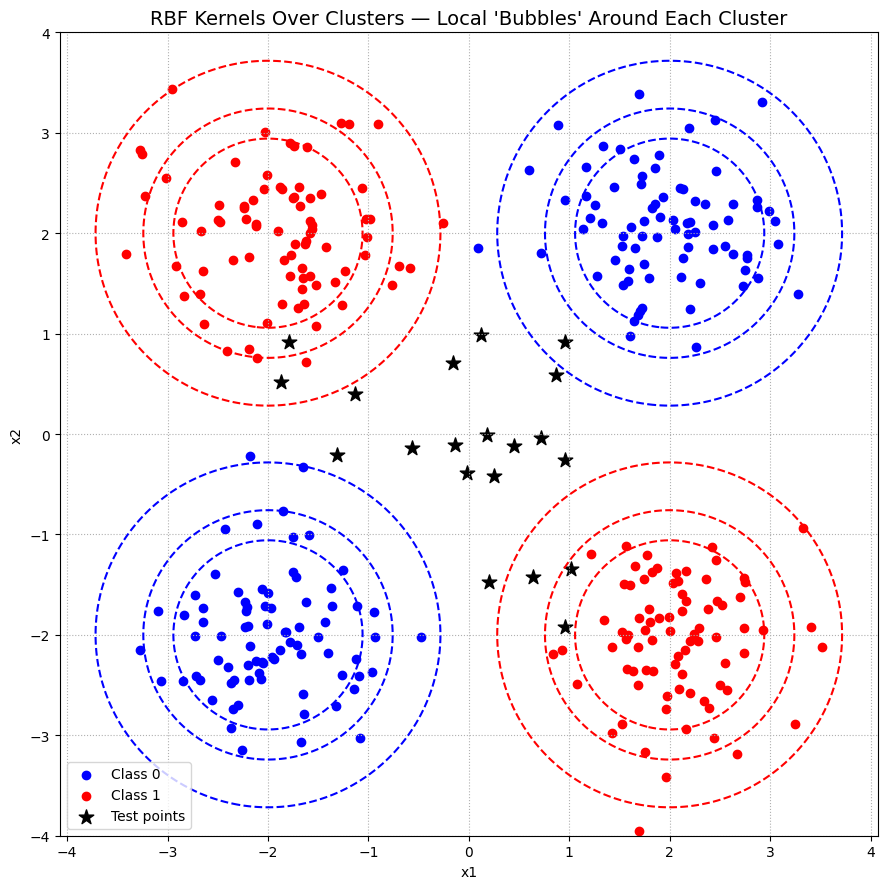

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1) تولید داده مشابه سؤال ۵
# ---------------------------------------------------------

# کلاس 0 (آبی): پایین-چپ و بالا-راست
cluster0_a = np.random.multivariate_normal([-2, -2], [[0.3, 0], [0, 0.3]], 80)
cluster0_b = np.random.multivariate_normal([ 2,  2], [[0.3, 0], [0, 0.3]], 80)

# کلاس 1 (قرمز): بالا-چپ و پایین-راست
cluster1_a = np.random.multivariate_normal([-2,  2], [[0.3, 0], [0, 0.3]], 80)
cluster1_b = np.random.multivariate_normal([ 2, -2], [[0.3, 0], [0, 0.3]], 80)

# نقاط تست وسط (ستاره‌های سیاه)
test_points = np.random.multivariate_normal([0, 0], [[0.5, 0], [0, 0.5]], 20)

# ---------------------------------------------------------
# 2) تعریف تابع RBF (گوسی)
# ---------------------------------------------------------
def rbf(x, center, sigma=0.8):
    """
    x:  آرایه‌ای از نقاط با شکل (N, 2)
    center: مرکز گوسی با شکل (1, 2)
    sigma: انحراف معیار گوسی
    """
    return np.exp(-np.sum((x - center)**2, axis=1) / (2 * sigma**2))

# ---------------------------------------------------------
# 3) گرید برای رسم RBF
# ---------------------------------------------------------
grid_x = np.linspace(-4, 4, 200)
grid_y = np.linspace(-4, 4, 200)
xx, yy = np.meshgrid(grid_x, grid_y)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# ---------------------------------------------------------
# 4) انتخاب مراکز گوسی برای هر خوشه
#    (برای نمایش، یک مرکز از هر خوشه)
# ---------------------------------------------------------
centers = np.array([
    [-2, -2],  # خوشه اول کلاس 0
    [ 2,  2],  # خوشه دوم کلاس 0
    [-2,  2],  # خوشه اول کلاس 1
    [ 2, -2],  # خوشه دوم کلاس 1
])

rbf_surfaces = [
    rbf(grid_points, c.reshape(1, 2), sigma=0.8).reshape(xx.shape)
    for c in centers
]

# ---------------------------------------------------------
# 5) رسم داده‌ها + کانتورهای RBF
# ---------------------------------------------------------
plt.figure(figsize=(9, 9))

# داده‌ها
plt.scatter(cluster0_a[:, 0], cluster0_a[:, 1], color='blue', label='Class 0')
plt.scatter(cluster0_b[:, 0], cluster0_b[:, 1], color='blue')
plt.scatter(cluster1_a[:, 0], cluster1_a[:, 1], color='red', label='Class 1')
plt.scatter(cluster1_b[:, 0], cluster1_b[:, 1], color='red')
plt.scatter(test_points[:, 0], test_points[:, 1],
            marker='*', color='black', s=120, label='Test points')

# کانتورهای گوسی (حباب‌های محلی RBF)
colors = ['blue', 'blue', 'red', 'red']
levels = [0.1, 0.3, 0.5]   # حتماً صعودی باشند

for i, surf in enumerate(rbf_surfaces):
    plt.contour(xx, yy, surf, levels=levels,
                colors=colors[i], linestyles='--')

plt.title("RBF Kernels Over Clusters — Local 'Bubbles' Around Each Cluster", fontsize=14)
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True, linestyle=':')
plt.legend()
plt.axis('equal')
plt.tight_layout()

# اگر برای گزارش می‌خوای ذخیره کنی:
# plt.savefig("Q5_RBF_visualized.png", dpi=300)

plt.show()


In [ ]:
import numpy as np

def generate_ball_beam_dataset(T=1000):
    """
    Generate dataset for the ball & beam system.
    System equation:
        y(t) = y(t-1) / (1 + y(t-2)) + u(t-1)^3
    Input:
        u(t) = sin(2*pi*t/250)

    Output:
        X       -> inputs [y(t-1), y(t-2), u(t-1)]
        y_target-> target outputs y(t)
        t_vals  -> time indices
        u_all   -> entire input signal
        y_all   -> entire system response
    """

    # time axis
    t = np.arange(T)

    # input signal
    u = np.sin(2 * np.pi * t / 250.0)

    # initialize output signal
    y = np.zeros(T)
    y[0] = 0.0
    y[1] = 0.0

    # simulate system
    for k in range(2, T):
        y[k] = y[k-1] / (1.0 + y[k-2]) + u[k-1]**3

    # build dataset for t >= 2
    N = T - 2
    X = np.zeros((N, 3))
    y_target = np.zeros(N)

    idx = 0
    for k in range(2, T):
        X[idx, 0] = y[k-1]
        X[idx, 1] = y[k-2]
        X[idx, 2] = u[k-1]
        y_target[idx] = y[k]
        idx += 1

    t_vals = np.arange(2, T)

    return X, y_target, t_vals, u, y


In [ ]:
# 1) Generate the full dataset (1000 samples)
X, y_target, t_vals, u_all, y_all = generate_ball_beam_dataset(T=1002)

print("Total samples:", X.shape[0])  # should be 1000

# 2) Split into train (first 700) and test (last 300)
n_train = 700

X_train = X[:n_train, :]
y_train = y_target[:n_train]

X_test  = X[n_train:, :]
y_test  = y_target[n_train:]

print("X_train shape:", X_train.shape)  # (700, 3)
print("y_train shape:", y_train.shape)  # (700,)
print("X_test shape:",  X_test.shape)   # (300, 3)
print("y_test shape:",  y_test.shape)   # (300,)


Total samples: 1000
X_train shape: (700, 3)
y_train shape: (700,)
X_test shape: (300, 3)
y_test shape: (300,)


In [ ]:
import numpy as np

def rbf(x, mu, sigma):
    return np.exp(-np.linalg.norm(x - mu)**2 / sigma**2)

x = np.array([1.5, 2.0])
mu = np.array([1.0, 1.0])
sigma = 1.0

phi_value = rbf(x, mu, sigma)
print("Activation:", phi_value)


Activation: 0.28650479686019004


In [ ]:
import numpy as np

# ----- RMSE -----
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# ----- Phi matrix -----
def compute_phi_matrix(X, centers, sigma):
    N = X.shape[0]
    K = centers.shape[0]
    Phi = np.zeros((N, K))
    for i in range(N):
        for j in range(K):
            Phi[i, j] = np.exp(-np.linalg.norm(X[i] - centers[j])**2 / sigma**2)
    return Phi

# ----- 1) Choose centers -----
K = 50
idx = np.random.choice(X_train.shape[0], K, replace=False)
centers = X_train[idx]

# ----- 2) Choose width -----
sigma = 0.5

# ----- 3) Compute Phi matrices -----
Phi_train = compute_phi_matrix(X_train, centers, sigma)
Phi_test  = compute_phi_matrix(X_test, centers, sigma)

# ----- 4) Solve for alpha -----
alpha, *_ = np.linalg.lstsq(Phi_train, y_train, rcond=None)

# ----- 5) Predictions -----
y_train_pred = Phi_train.dot(alpha)
y_test_pred  = Phi_test.dot(alpha)

# ----- 6) RMSE -----
rmse_train = rmse(y_train, y_train_pred)
rmse_test  = rmse(y_test, y_test_pred)

print("Train RMSE =", rmse_train)
print("Test RMSE  =", rmse_test)


Train RMSE = 13.371354367802374
Test RMSE  = 20.023009694101024


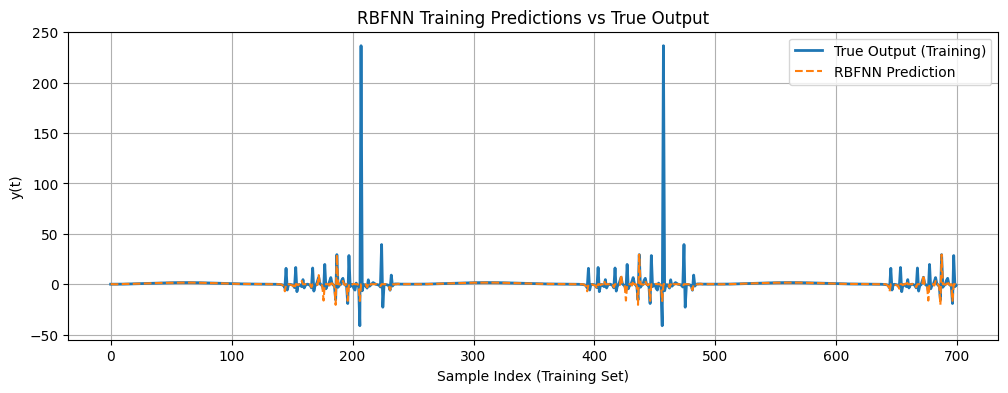

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(y_train, label="True Output (Training)", linewidth=2)
plt.plot(y_train_pred, label="RBFNN Prediction", linestyle='--')
plt.xlabel("Sample Index (Training Set)")
plt.ylabel("y(t)")
plt.title("RBFNN Training Predictions vs True Output")
plt.legend()
plt.grid(True)
plt.show()


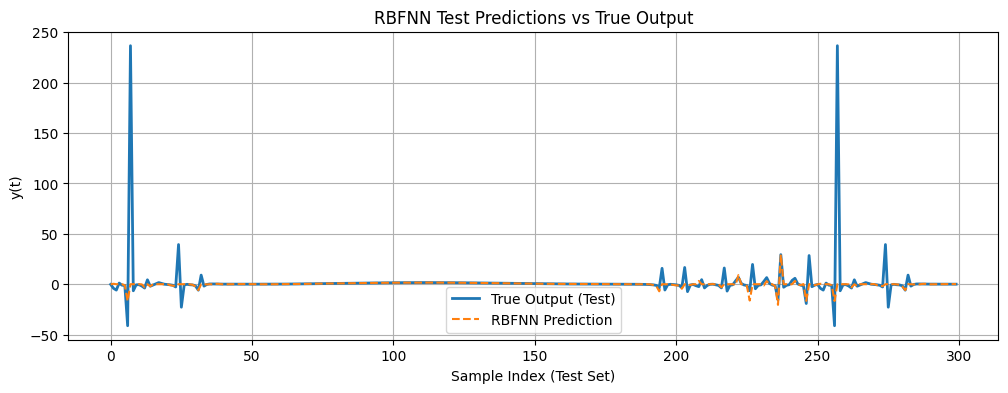

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(y_test, label="True Output (Test)", linewidth=2)
plt.plot(y_test_pred, label="RBFNN Prediction", linestyle='--')
plt.xlabel("Sample Index (Test Set)")
plt.ylabel("y(t)")
plt.title("RBFNN Test Predictions vs True Output")
plt.legend()
plt.grid(True)
plt.show()


K =  10  →  Train RMSE = 13.6739,  Test RMSE = 20.2513
K =  20  →  Train RMSE = 13.7191,  Test RMSE = 20.3247
K =  50  →  Train RMSE = 13.4584,  Test RMSE = 20.0971
K = 100  →  Train RMSE = 13.0844,  Test RMSE = 19.8200
K = 200  →  Train RMSE = 12.8581,  Test RMSE = 19.4935


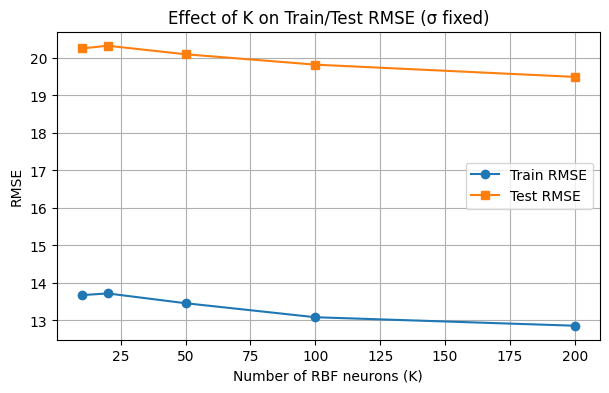

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ----- SETTINGS -----
K_list = [10, 20, 50, 100, 200]   # different numbers of RBF neurons
sigma  = 0.5                      # keep σ fixed (same as before)

train_rmse_list = []
test_rmse_list  = []

for K in K_list:
    # 1) choose K centers randomly from training data
    idx = np.random.choice(X_train.shape[0], K, replace=False)
    centers = X_train[idx]

    # 2) compute Φ for train and test
    Phi_train = compute_phi_matrix(X_train, centers, sigma)
    Phi_test  = compute_phi_matrix(X_test,  centers, sigma)

    # 3) solve for α with least squares
    alpha, *_ = np.linalg.lstsq(Phi_train, y_train, rcond=None)

    # 4) predictions
    y_train_pred = Phi_train.dot(alpha)
    y_test_pred  = Phi_test.dot(alpha)

    # 5) RMSE
    rmse_train = rmse(y_train, y_train_pred)
    rmse_test  = rmse(y_test,  y_test_pred)

    train_rmse_list.append(rmse_train)
    test_rmse_list.append(rmse_test)

    print(f"K = {K:3d}  →  Train RMSE = {rmse_train:.4f},  Test RMSE = {rmse_test:.4f}")

# ----- Plot RMSE vs K -----
plt.figure(figsize=(7,4))
plt.plot(K_list, train_rmse_list, marker='o', label='Train RMSE')
plt.plot(K_list, test_rmse_list,  marker='s', label='Test RMSE')
plt.xlabel("Number of RBF neurons (K)")
plt.ylabel("RMSE")
plt.title("Effect of K on Train/Test RMSE (σ fixed)")
plt.legend()
plt.grid(True)
plt.show()


sigma =  0.5  →  Train RMSE = 13.2111,  Test RMSE = 19.9078
sigma =  1.0  →  Train RMSE = 12.9973,  Test RMSE = 19.6135
sigma =  5.0  →  Train RMSE = 13.0274,  Test RMSE = 19.8308
sigma =  7.0  →  Train RMSE = 13.0401,  Test RMSE = 19.8398
sigma = 10.0  →  Train RMSE = 13.0259,  Test RMSE = 19.7309


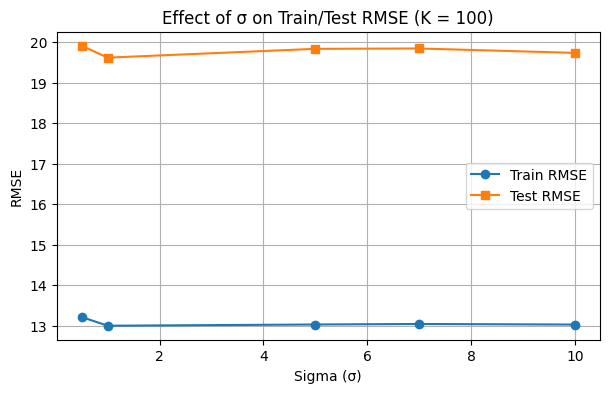

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_phi_matrix(X, centers, sigma):
    N = X.shape[0]
    K = centers.shape[0]
    Phi = np.zeros((N, K))
    for i in range(N):
        for j in range(K):
            Phi[i, j] = np.exp(-np.linalg.norm(X[i] - centers[j])**2 / sigma**2)
    return Phi

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# ----- SETTINGS -----
K = 100                         # fixed number of neurons
sigma_list = [0.5, 1, 5, 7, 10] # values to test

np.random.seed(42)  # for reproducibility

# 1) Choose centers ONCE from training data
idx = np.random.choice(X_train.shape[0], K, replace=False)
centers = X_train[idx]

train_rmse_sigma = []
test_rmse_sigma  = []

for sigma in sigma_list:
    # 2) Build Phi for this sigma
    Phi_train = compute_phi_matrix(X_train, centers, sigma)
    Phi_test  = compute_phi_matrix(X_test,  centers, sigma)

    # 3) Least-squares solution for alpha
    alpha, *_ = np.linalg.lstsq(Phi_train, y_train, rcond=None)

    # 4) Predictions
    y_train_pred = Phi_train @ alpha
    y_test_pred  = Phi_test  @ alpha

    # 5) RMSE
    rmse_train = rmse(y_train, y_train_pred)
    rmse_test  = rmse(y_test,  y_test_pred)

    train_rmse_sigma.append(rmse_train)
    test_rmse_sigma.append(rmse_test)

    print(f"sigma = {sigma:4.1f}  →  Train RMSE = {rmse_train:.4f},  Test RMSE = {rmse_test:.4f}")

# ----- Plot -----
plt.figure(figsize=(7,4))
plt.plot(sigma_list, train_rmse_sigma, marker='o', label="Train RMSE")
plt.plot(sigma_list, test_rmse_sigma,  marker='s', label="Test RMSE")
plt.xlabel("Sigma (σ)")
plt.ylabel("RMSE")
plt.title(f"Effect of σ on Train/Test RMSE (K = {K})")
plt.legend()
plt.grid(True)
plt.show()


lambda =  0.001 → Train RMSE = 2.7564, Test RMSE = 3.8926
lambda =  0.010 → Train RMSE = 2.7699, Test RMSE = 3.9159
lambda =  0.100 → Train RMSE = 2.8706, Test RMSE = 4.0902
lambda =  1.000 → Train RMSE = 5.1865, Test RMSE = 7.7392
lambda = 10.000 → Train RMSE = 11.2933, Test RMSE = 16.9160


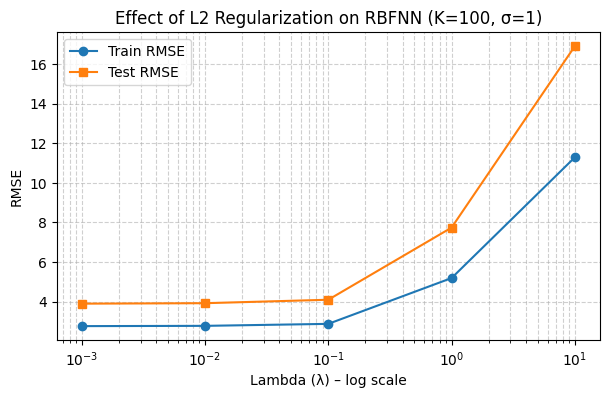

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- helpers from before (keep as you had) ---
def compute_phi_matrix(X, centers, sigma):
    N = X.shape[0]
    K = centers.shape[0]
    Phi = np.zeros((N, K))
    for i in range(N):
        for j in range(K):
            Phi[i, j] = np.exp(-np.linalg.norm(X[i] - centers[j])**2 / sigma**2)
    return Phi

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# fix seed for reproducibility
np.random.seed(0)

# --- fixed architecture: K=100, sigma=1 ---
K = 200
sigma = 0.5

# choose centers once from training data
idx = np.random.choice(X_train.shape[0], K, replace=False)
centers = X_train[idx]

# build Phi for train and test (will be reused for all lambdas)
Phi_train = compute_phi_matrix(X_train, centers, sigma)
Phi_test  = compute_phi_matrix(X_test,  centers, sigma)

lambdas = [0.001, 0.01, 0.1, 1.0, 10.0]

train_rmse_list = []
test_rmse_list  = []
alpha_list      = []   # store alphas for each lambda

K = Phi_train.shape[1]
I = np.eye(K)

for lam in lambdas:
    # ridge solution: (ΦᵀΦ + λI)α = Φᵀy
    PhiT_Phi = Phi_train.T @ Phi_train
    PhiT_y   = Phi_train.T @ y_train

    alpha = np.linalg.solve(PhiT_Phi + lam * I, PhiT_y)

    # predictions
    y_train_pred = Phi_train @ alpha
    y_test_pred  = Phi_test  @ alpha

    # RMSE
    rmse_train = rmse(y_train, y_train_pred)
    rmse_test  = rmse(y_test,  y_test_pred)

    train_rmse_list.append(rmse_train)
    test_rmse_list.append(rmse_test)
    alpha_list.append(alpha)

    print(f"lambda = {lam:6.3f} → Train RMSE = {rmse_train:.4f}, Test RMSE = {rmse_test:.4f}")

plt.figure(figsize=(7,4))
plt.semilogx(lambdas, train_rmse_list, marker='o', label='Train RMSE')
plt.semilogx(lambdas, test_rmse_list,  marker='s', label='Test RMSE')
plt.xlabel("Lambda (λ) – log scale")
plt.ylabel("RMSE")
plt.title("Effect of L2 Regularization on RBFNN (K=100, σ=1)")
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.legend()
plt.show()

Chosen lambda = 0.1
Chosen alpha shape: (200,)
Train RMSE (λ=0.1): 2.870601016794148
Test  RMSE (λ=0.1): 4.090223633094035


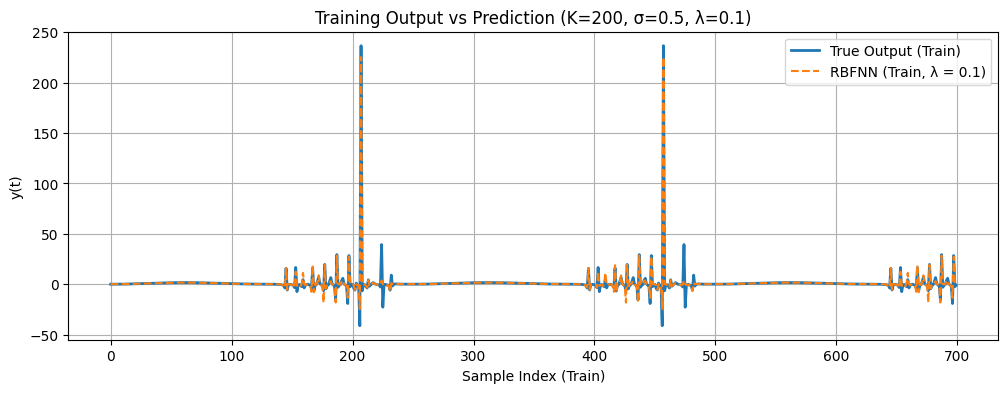

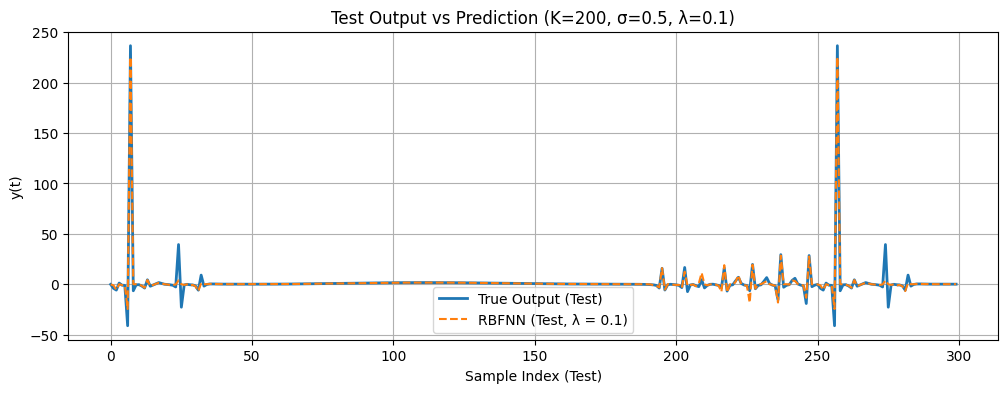

In [ ]:
# ----- choose lambda explicitly -----
chosen_lambda = 0.1

# find its index in the lambdas list
chosen_idx = lambdas.index(chosen_lambda)

# corresponding weight vector
chosen_alpha = alpha_list[chosen_idx]

print("Chosen lambda =", chosen_lambda)
print("Chosen alpha shape:", chosen_alpha.shape)

# RMSE for this lambda (optional)
print("Train RMSE (λ=0.1):", train_rmse_list[chosen_idx])
print("Test  RMSE (λ=0.1):", test_rmse_list[chosen_idx])

# predictions for λ = 0.1
y_train_pred_lam = Phi_train @ chosen_alpha
y_test_pred_lam  = Phi_test  @ chosen_alpha

plt.figure(figsize=(12,4))
plt.plot(y_train, label="True Output (Train)", linewidth=2)
plt.plot(y_train_pred_lam, '--', label="RBFNN (Train, λ = 0.1)")
plt.xlabel("Sample Index (Train)")
plt.ylabel("y(t)")
plt.title("Training Output vs Prediction (K=200, σ=0.5, λ=0.1)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(y_test, label="True Output (Test)", linewidth=2)
plt.plot(y_test_pred_lam, '--', label="RBFNN (Test, λ = 0.1)")
plt.xlabel("Sample Index (Test)")
plt.ylabel("y(t)")
plt.title("Test Output vs Prediction (K=200, σ=0.5, λ=0.1)")
plt.legend()
plt.grid(True)
plt.show()


alpha_km shape: (50,)
[K-Means centers, σ=0.5, K=50]
Train RMSE = 2.8451
Test  RMSE = 3.8198


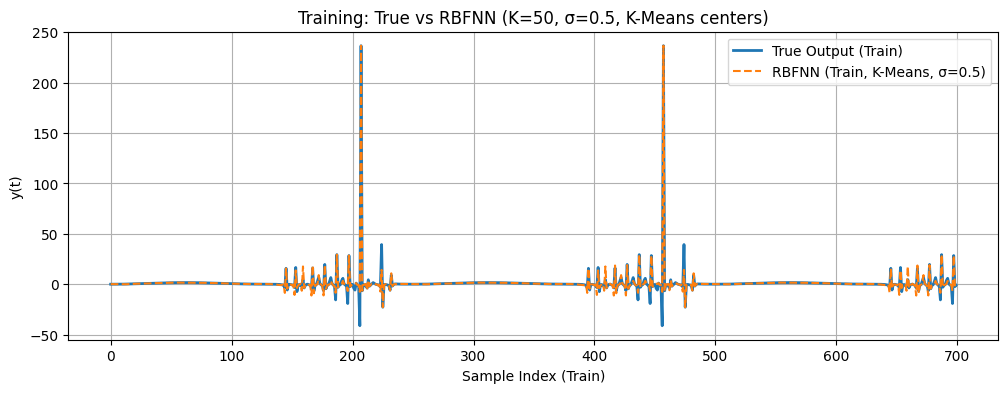

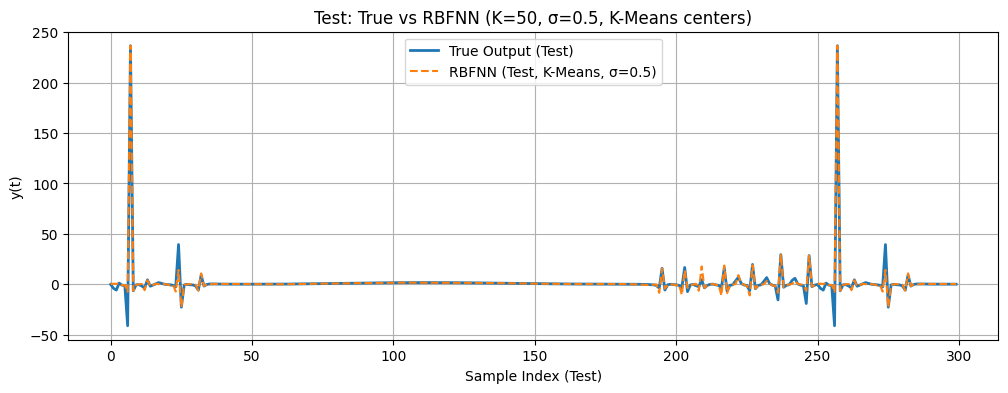

Random centers → Train RMSE = 11.293257144967903 , Test RMSE = 16.91599416786017
K-Means centers → Train RMSE = 2.8451025503236886 , Test RMSE = 3.819845212348962


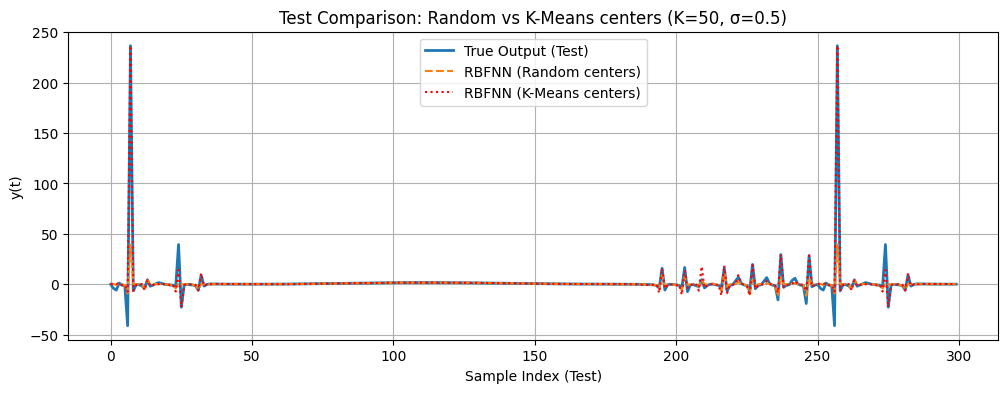

In [ ]:
from sklearn.cluster import KMeans

# ---- settings for 1.5.1 ----
K = 50          # same as 1.3.1
sigma = 0.5      # same as 1.3.1

# ----- 1) K-Means clustering on X_train to find centers -----
kmeans = KMeans(n_clusters=K, n_init=10, random_state=0)
kmeans.fit(X_train)
centers_km = kmeans.cluster_centers_   # shape: (K, input_dim)

# ----- 2) Build Phi matrices for train and test -----
Phi_train_km = compute_phi_matrix(X_train, centers_km, sigma)
Phi_test_km  = compute_phi_matrix(X_test,  centers_km, sigma)

# ----- 3) Solve for weights with plain least squares (NO regularization) -----
alpha_km, *_ = np.linalg.lstsq(Phi_train_km, y_train, rcond=None)

print("alpha_km shape:", alpha_km.shape)

# ----- 4) Predictions -----
y_train_pred_km = Phi_train_km @ alpha_km
y_test_pred_km  = Phi_test_km  @ alpha_km

# ----- 5) RMSEs -----
train_rmse_km = rmse(y_train, y_train_pred_km)
test_rmse_km  = rmse(y_test,  y_test_pred_km)

print(f"[K-Means centers, σ={sigma}, K={K}]")
print(f"Train RMSE = {train_rmse_km:.4f}")
print(f"Test  RMSE = {test_rmse_km:.4f}")

plt.figure(figsize=(12,4))
plt.plot(y_train, label="True Output (Train)", linewidth=2)
plt.plot(y_train_pred_km, '--', label=f"RBFNN (Train, K-Means, σ={sigma})")
plt.xlabel("Sample Index (Train)")
plt.ylabel("y(t)")
plt.title(f"Training: True vs RBFNN (K={K}, σ={sigma}, K-Means centers)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(y_test, label="True Output (Test)", linewidth=2)
plt.plot(y_test_pred_km, '--', label=f"RBFNN (Test, K-Means, σ={sigma})")
plt.xlabel("Sample Index (Test)")
plt.ylabel("y(t)")
plt.title(f"Test: True vs RBFNN (K={K}, σ={sigma}, K-Means centers)")
plt.legend()
plt.grid(True)
plt.show()

print("Random centers → Train RMSE =", rmse_train, ", Test RMSE =", rmse_test)
print("K-Means centers → Train RMSE =", train_rmse_km, ", Test RMSE =", test_rmse_km)

plt.figure(figsize=(12,4))
plt.plot(y_test, label="True Output (Test)", linewidth=2)
plt.plot(y_test_pred,   '--', label="RBFNN (Random centers)")
plt.plot(y_test_pred_km, ':',  label="RBFNN (K-Means centers)", color = "red")
plt.xlabel("Sample Index (Test)")
plt.ylabel("y(t)")
plt.title(f"Test Comparison: Random vs K-Means centers (K={K}, σ={sigma})")
plt.legend()
plt.grid(True)
plt.show()


[1.5.2] Nearest-Neighbor σ, K-Means centers, K=50
Train RMSE = 2.8364
Test  RMSE = 3.7913


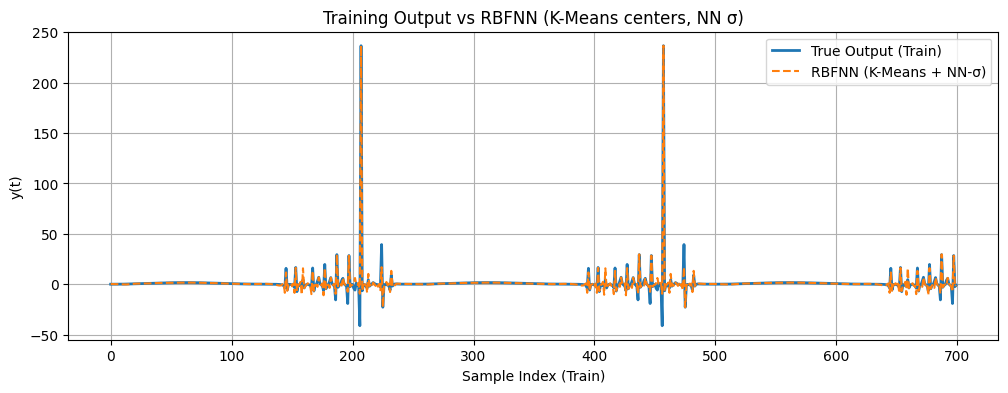

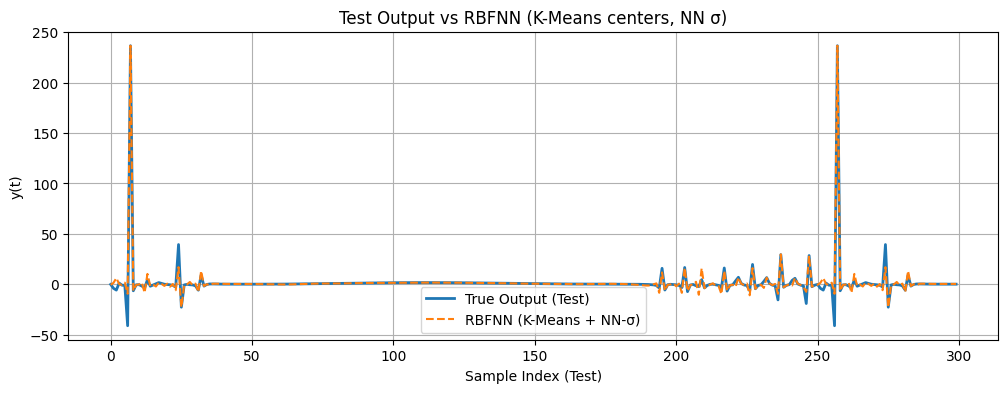

In [ ]:
def compute_sigma_knn(centers, p=2):
    K = centers.shape[0]
    sigmas = np.zeros(K)

    # Compute distances between all centers
    dist = np.linalg.norm(
        centers[:, None, :] - centers[None, :, :],
        axis=2
    )
    np.fill_diagonal(dist, np.inf)  # ignore self-distance

    # For each center: find p-th nearest neighbor
    for k in range(K):
        sorted_dist = np.sort(dist[k])
        sigmas[k] = sorted_dist[p-1]   # p=2 → 2nd nearest neighbor

    return sigmas

def compute_phi_variable_sigma(X, centers, sigmas):
    N = X.shape[0]
    K = centers.shape[0]
    Phi = np.zeros((N, K))

    for i in range(N):
        for k in range(K):
            Phi[i, k] = np.exp(
                -np.linalg.norm(X[i] - centers[k])**2 / (sigmas[k]**2)
            )
    return Phi

# --- settings ---
K = 50
p = 2

# 1) K-means centers (reuse previous code)
kmeans = KMeans(n_clusters=K, n_init=10, random_state=0)
kmeans.fit(X_train)
centers_km = kmeans.cluster_centers_

# 2) compute sigmas using nearest-neighbor
sigmas_knn = compute_sigma_knn(centers_km, p=2)

# 3) build Phi for train and test
Phi_train_knn = compute_phi_variable_sigma(X_train, centers_km, sigmas_knn)
Phi_test_knn  = compute_phi_variable_sigma(X_test,  centers_km, sigmas_knn)

# 4) solve with normal least squares
alpha_knn, *_ = np.linalg.lstsq(Phi_train_knn, y_train, rcond=None)

# 5) predictions
y_train_pred_knn = Phi_train_knn @ alpha_knn
y_test_pred_knn  = Phi_test_knn  @ alpha_knn

# 6) RMSE
train_rmse_knn = rmse(y_train, y_train_pred_knn)
test_rmse_knn  = rmse(y_test,  y_test_pred_knn)

print(f"[1.5.2] Nearest-Neighbor σ, K-Means centers, K={K}")
print(f"Train RMSE = {train_rmse_knn:.4f}")
print(f"Test  RMSE = {test_rmse_knn:.4f}")

plt.figure(figsize=(12,4))
plt.plot(y_train, label="True Output (Train)", linewidth=2)
plt.plot(y_train_pred_knn, '--', label="RBFNN (K-Means + NN-σ)")
plt.xlabel("Sample Index (Train)")
plt.ylabel("y(t)")
plt.title("Training Output vs RBFNN (K-Means centers, NN σ)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(y_test, label="True Output (Test)", linewidth=2)
plt.plot(y_test_pred_knn, '--', label="RBFNN (K-Means + NN-σ)")
plt.xlabel("Sample Index (Test)")
plt.ylabel("y(t)")
plt.title("Test Output vs RBFNN (K-Means centers, NN σ)")
plt.legend()
plt.grid(True)
plt.show()



=== Model 1: e_min=0.5, eps=1.0 ===


/tmp/ipython-input-3419755125.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_hat_n = float(Phi_n @ alpha)


Train RMSE = 3.0069
Test  RMSE = 4.1263
Number of neurons (centers) = 41

=== Model 2: e_min=0.25, eps=0.5 ===
Train RMSE = 1.8766
Test  RMSE = 2.5272
Number of neurons (centers) = 62

=== Model 3: e_min=0.125, eps=0.25 ===
Train RMSE = 0.6442
Test  RMSE = 0.6299
Number of neurons (centers) = 87


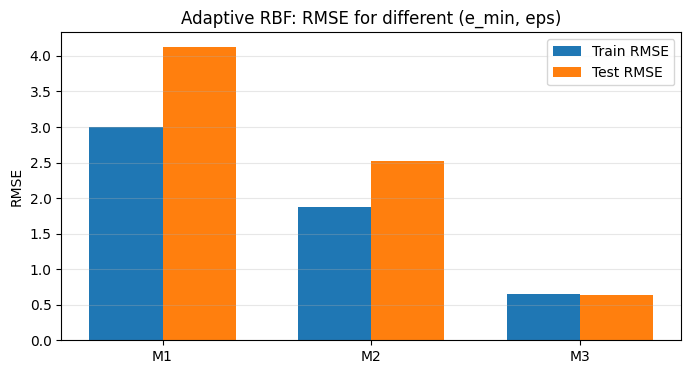

M1: Model 1: e_min=0.5, eps=1.0 → Neurons = 41, Train RMSE = 3.0069, Test RMSE = 4.1263
M2: Model 2: e_min=0.25, eps=0.5 → Neurons = 62, Train RMSE = 1.8766, Test RMSE = 2.5272
M3: Model 3: e_min=0.125, eps=0.25 → Neurons = 87, Train RMSE = 0.6442, Test RMSE = 0.6299


In [ ]:
# --------------------------------------------------
# Adaptive RBF trainer with growth rule (2.1.1)
# --------------------------------------------------
def train_adaptive_rbf(
    X_train, y_train, X_test, y_test,
    eps, e_min,
    sigma=1.0
):
    """
    Online/growing RBF:
      - starts empty
      - goes through training samples one by one
      - uses growth rule:
          if |e_n| > e_min AND dist_to_nearest_center > eps
        then add a new center at x_n
      - after each sample, re-fit weights on all seen data via least squares
    Returns: train_rmse, test_rmse, n_centers, centers, alpha
    """
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    X_test  = np.asarray(X_test)
    y_test  = np.asarray(y_test)

    centers = []
    alpha = None

    X_seen = []
    y_seen = []

    for n in range(len(X_train)):
        x_n = X_train[n]
        y_n = y_train[n]

        # first sample → must create first center
        if len(centers) == 0:
            centers.append(x_n.copy())
            X_seen.append(x_n)
            y_seen.append(y_n)

            Phi_seen = compute_phi_matrix(np.array(X_seen), np.array(centers), sigma)
            alpha, *_ = np.linalg.lstsq(Phi_seen, np.array(y_seen), rcond=None)
            continue

        centers_arr = np.array(centers)

        # current prediction with existing network
        Phi_n = compute_phi_matrix(x_n.reshape(1, -1), centers_arr, sigma)
        y_hat_n = float(Phi_n @ alpha)

        # error criterion
        err = abs(y_n - y_hat_n)

        # novelty criterion
        dists = np.linalg.norm(centers_arr - x_n, axis=1)
        min_dist = float(np.min(dists))

        # growth rule (2.1.1): add neuron if BOTH criteria are satisfied
        if (err > e_min) and (min_dist > eps):
            centers.append(x_n.copy())
            centers_arr = np.array(centers)

        # add sample to seen set
        X_seen.append(x_n)
        y_seen.append(y_n)

        # re-fit weights on all seen data and current centers
        Phi_seen = compute_phi_matrix(np.array(X_seen), centers_arr, sigma)
        alpha, *_ = np.linalg.lstsq(Phi_seen, np.array(y_seen), rcond=None)

    # final train/test RMSE with last centers & alpha
    centers_arr = np.array(centers)
    Phi_train_final = compute_phi_matrix(X_train, centers_arr, sigma)
    Phi_test_final  = compute_phi_matrix(X_test,  centers_arr, sigma)

    y_train_pred = Phi_train_final @ alpha
    y_test_pred  = Phi_test_final  @ alpha

    train_rmse = rmse(y_train, y_train_pred)
    test_rmse  = rmse(y_test,  y_test_pred)

    return train_rmse, test_rmse, len(centers), centers_arr, alpha

# --------------------------------------------------
# Run 3 models with different (e_min, eps)
# --------------------------------------------------

configs = [
    ("Model 1: e_min=0.5, eps=1.0", 0.5, 1.0),
    ("Model 2: e_min=0.25, eps=0.5", 0.25, 0.5),
    ("Model 3: e_min=0.125, eps=0.25", 0.125, 0.25),
]

results = []

for name, e_min, eps in configs:
    print(f"\n=== {name} ===")
    tr_rmse, te_rmse, n_centers, centers, alpha = train_adaptive_rbf(
        X_train, y_train, X_test, y_test,
        eps=eps, e_min=e_min, sigma=1.0  # we keep sigma=1 consistent with part1
    )
    print(f"Train RMSE = {tr_rmse:.4f}")
    print(f"Test  RMSE = {te_rmse:.4f}")
    print(f"Number of neurons (centers) = {n_centers}")
    results.append((name, tr_rmse, te_rmse, n_centers))

# --------------------------------------------------
# Plot RMSE comparison
# --------------------------------------------------

labels = [r[0] for r in results]
train_vals = [r[1] for r in results]
test_vals  = [r[2] for r in results]
neuron_cnt = [r[3] for r in results]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,4))
plt.bar(x - width/2, train_vals, width, label="Train RMSE")
plt.bar(x + width/2, test_vals,  width, label="Test RMSE")
plt.xticks(x, [f"M{i+1}" for i in range(len(labels))])
plt.ylabel("RMSE")
plt.title("Adaptive RBF: RMSE for different (e_min, eps)")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# Also print neuron counts clearly
for i, (name, tr, te, n) in enumerate(results, start=1):
    print(f"M{i}: {name} → Neurons = {n}, Train RMSE = {tr:.4f}, Test RMSE = {te:.4f}")


In [ ]:
import numpy as np

# ---------- Helpers ----------

def rbf_activity(x, centers, sigmas):
    """Compute phi_k(x) for all centers."""
    if len(centers) == 0:
        return np.array([])
    centers = np.asarray(centers)
    sigmas = np.asarray(sigmas)
    diff = centers - x  # (K, d)
    dist2 = np.sum(diff**2, axis=1)
    return np.exp(-dist2 / (sigmas**2 + 1e-12))


def update_sigmas_from_centers(centers, k_overlap=0.8, default_sigma=1.0):
    """sigma_k = k_overlap * distance_to_nearest_other_center."""
    centers = np.asarray(centers)
    K = centers.shape[0]
    if K == 1:
        return np.array([default_sigma], dtype=float)
    sigmas = np.zeros(K)
    for i in range(K):
        diff = centers[i] - centers
        dist = np.linalg.norm(diff, axis=1)
        dist[i] = np.inf
        d_min = np.min(dist)
        sigmas[i] = k_overlap * d_min
    return sigmas


def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))


# ---------- MRAN-style LMS with single pruning (delta, M) ----------

def train_mran_lms_single_prune(
    X_train, y_train, X_test, y_test,
    e_min=0.125,
    eps=0.25,
    k_overlap=0.8,
    eta=0.05,
    delta=0.01,
    M_inactive=50,
    warmup=50,
    min_neurons=5
):
    """
    Adaptive RBF with:
      - Growth: |e| > e_min AND dist > eps
      - LMS on output weights
      - Single participation-based pruning with (delta, M_inactive)
    Returns:
      train_rmse, test_rmse, final_num_neurons
    """

    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    X_test  = np.asarray(X_test)
    y_test  = np.asarray(y_test)

    N_train, d = X_train.shape

    centers = []
    sigmas = np.array([])
    alpha = np.array([])
    inactive_count = np.array([], dtype=int)

    for n in range(N_train):
        x_n = X_train[n]
        y_n = y_train[n]

        # First sample -> initialize one neuron
        if len(centers) == 0:
            centers.append(x_n.copy())
            centers_arr = np.array(centers)
            sigmas = update_sigmas_from_centers(centers_arr, k_overlap=k_overlap,
                                                default_sigma=1.0)
            alpha = np.zeros(1, dtype=float)
            inactive_count = np.zeros(1, dtype=int)
            continue

        centers_arr = np.array(centers)
        K = centers_arr.shape[0]

        # align shapes
        if sigmas.shape[0] != K:
            sigmas = update_sigmas_from_centers(centers_arr, k_overlap=k_overlap,
                                                default_sigma=1.0)
        if alpha.shape[0] != K:
            alpha = np.resize(alpha, K)
        if inactive_count.shape[0] != K:
            inactive_count = np.resize(inactive_count, K)
            inactive_count[:] = 0

        # forward
        phi_n = rbf_activity(x_n, centers_arr, sigmas)  # (K,)
        y_hat_n = float(np.dot(alpha, phi_n))
        e_n = y_n - y_hat_n

        # growth rule
        dists = np.linalg.norm(centers_arr - x_n, axis=1)
        min_dist = float(np.min(dists))
        if (abs(e_n) > e_min) and (min_dist > eps):
            centers.append(x_n.copy())
            centers_arr = np.array(centers)
            sigmas = update_sigmas_from_centers(centers_arr, k_overlap=k_overlap,
                                                default_sigma=1.0)
            alpha = np.concatenate([alpha, np.array([0.0])])
            inactive_count = np.concatenate([inactive_count, np.array([0], dtype=int)])
            phi_n = rbf_activity(x_n, centers_arr, sigmas)
            y_hat_n = float(np.dot(alpha, phi_n))
            e_n = y_n - y_hat_n

        # LMS update
        alpha = alpha + eta * e_n * phi_n

        # pruning (after warmup)
        if n >= warmup and len(centers) > 0:
            o_n = alpha * phi_n
            max_o = np.max(np.abs(o_n))
            if max_o > 0:
                r_n = np.abs(o_n) / max_o
            else:
                r_n = np.zeros_like(o_n)

            low_part = r_n < delta
            inactive_count[low_part] += 1
            inactive_count[~low_part] = 0

            # prune if too long inactive and we still have enough neurons
            to_keep = np.ones(len(centers), dtype=bool)
            for k in range(len(centers)):
                if inactive_count[k] > M_inactive and len(centers) > min_neurons:
                    to_keep[k] = False

            if not np.all(to_keep):
                centers_arr = centers_arr[to_keep]
                sigmas = sigmas[to_keep]
                alpha = alpha[to_keep]
                inactive_count = inactive_count[to_keep]
                centers = [c for c, keep in zip(centers, to_keep) if keep]

    # final evaluation
    centers_arr = np.array(centers)
    K = centers_arr.shape[0]
    if K == 0:
        return 1e9, 1e9, 0

    Phi_train = np.vstack([rbf_activity(x, centers_arr, sigmas) for x in X_train])
    Phi_test  = np.vstack([rbf_activity(x, centers_arr, sigmas) for x in X_test])

    y_train_pred = Phi_train @ alpha
    y_test_pred  = Phi_test  @ alpha

    tr_rmse = rmse(y_train, y_train_pred)
    te_rmse = rmse(y_test,  y_test_pred)

    return tr_rmse, te_rmse, K


# ---------- Grid search over (delta, M) ----------

# Question's recommended pairs (low & medium pruning) and some neighbors
delta_list = [0.005, 0.01, 0.02, 0.05]   # includes 0.01 and 0.05
M_list     = [20, 40, 60, 80, 100]       # includes 50/100 region

eta = 0.05  # your preferred learning rate

results = []

for delta in delta_list:
    for M_inactive in M_list:
        tr_rmse, te_rmse, K = train_mran_lms_single_prune(
            X_train, y_train, X_test, y_test,
            e_min=0.125,
            eps=0.25,
            k_overlap=0.8,
            eta=eta,
            delta=delta,
            M_inactive=M_inactive,
            warmup=50,     # can change if you want
            min_neurons=5
        )
        print(f"delta={delta:.3f}, M={M_inactive:3d} "
              f"-> Train RMSE={tr_rmse:.4f}, Test RMSE={te_rmse:.4f}, Neurons={K}")
        results.append({
            "delta": delta,
            "M": M_inactive,
            "train_rmse": tr_rmse,
            "test_rmse": te_rmse,
            "neurons": K
        })

# sort by Test RMSE first, then by number of neurons
results_sorted = sorted(results, key=lambda r: (r["test_rmse"], r["neurons"]))

print("\nTop 5 configurations by Test RMSE:")
for r in results_sorted[:5]:
    print(f"delta={r['delta']:.3f}, M={r['M']:3d}, "
          f"Neurons={r['neurons']}, "
          f"Train RMSE={r['train_rmse']:.4f}, Test RMSE={r['test_rmse']:.4f}")


delta=0.005, M= 20 -> Train RMSE=12.6788, Test RMSE=18.7005, Neurons=33
delta=0.005, M= 40 -> Train RMSE=12.6727, Test RMSE=18.7374, Neurons=49
delta=0.005, M= 60 -> Train RMSE=12.6261, Test RMSE=18.6718, Neurons=58
delta=0.005, M= 80 -> Train RMSE=12.5551, Test RMSE=18.5744, Neurons=62
delta=0.005, M=100 -> Train RMSE=12.5451, Test RMSE=18.5686, Neurons=63
delta=0.010, M= 20 -> Train RMSE=12.6404, Test RMSE=18.6826, Neurons=33
delta=0.010, M= 40 -> Train RMSE=12.6367, Test RMSE=18.6952, Neurons=48
delta=0.010, M= 60 -> Train RMSE=12.6594, Test RMSE=18.7202, Neurons=54
delta=0.010, M= 80 -> Train RMSE=12.5421, Test RMSE=18.5676, Neurons=61
delta=0.010, M=100 -> Train RMSE=12.5552, Test RMSE=18.5774, Neurons=62
delta=0.020, M= 20 -> Train RMSE=12.6470, Test RMSE=18.7085, Neurons=27
delta=0.020, M= 40 -> Train RMSE=12.6538, Test RMSE=18.7151, Neurons=44
delta=0.020, M= 60 -> Train RMSE=12.6842, Test RMSE=18.7484, Neurons=53
delta=0.020, M= 80 -> Train RMSE=12.6048, Test RMSE=18.6400, Neu

Adaptive HP MRAN+LMS (eta=0.05)
Final neurons = 55
Train RMSE = 12.6622
Test  RMSE = 18.7330


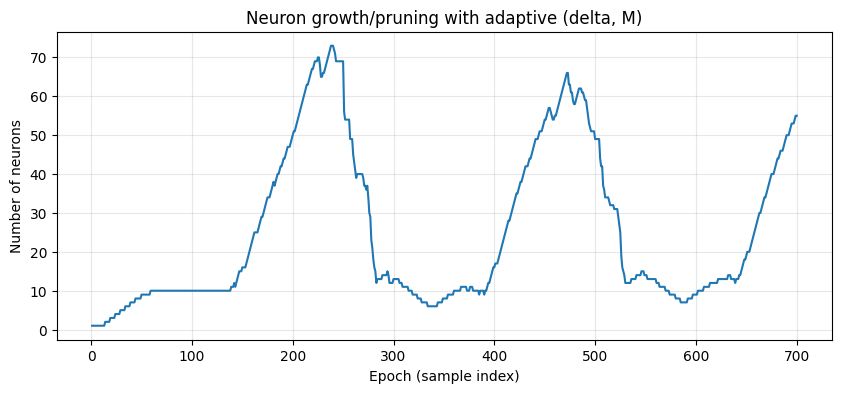

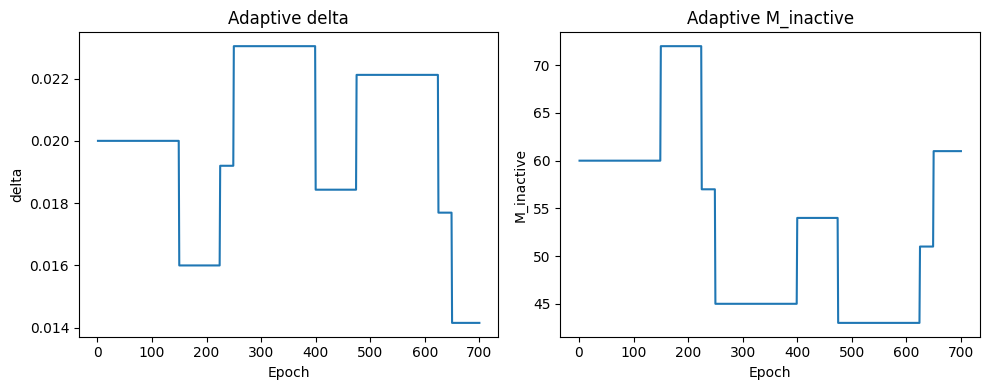

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Utilities ----------

def rbf_activity(x, centers, sigmas):
    """Compute phi_k(x) for all centers."""
    if len(centers) == 0:
        return np.array([])
    centers = np.asarray(centers)
    sigmas = np.asarray(sigmas)
    diff = centers - x  # (K, d)
    dist2 = np.sum(diff**2, axis=1)
    return np.exp(-dist2 / (sigmas**2 + 1e-12))


def update_sigmas_from_centers(centers, k_overlap=0.8, default_sigma=1.0):
    """sigma_k = k_overlap * distance_to_nearest_other_center."""
    centers = np.asarray(centers)
    K = centers.shape[0]
    if K == 1:
        return np.array([default_sigma], dtype=float)
    sigmas = np.zeros(K)
    for i in range(K):
        diff = centers[i] - centers
        dist = np.linalg.norm(diff, axis=1)
        dist[i] = np.inf
        d_min = np.min(dist)
        sigmas[i] = k_overlap * d_min
    return sigmas


def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))


# ---------- MRAN + LMS with adaptive (delta, M) ----------

def train_mran_lms_adaptive_hp(
    X_train, y_train, X_test, y_test,
    e_min=0.125,
    eps=0.25,
    k_overlap=0.8,
    eta=0.05,
    # initial pruning hyperparams
    delta_init=0.02,
    M_init=60,
    # bounds for hyperparams
    delta_min=0.001,
    delta_max=0.1,
    M_min=10,
    M_max=120,
    # meta-control
    warmup=80,           # no pruning / adaptation before this
    meta_interval=25,    # how often to adjust hyperparams
    err_window=50,       # sliding window length for RMS error
    K_low=20,            # target neuron count band (lower)
    K_high=60,           # target neuron count band (upper)
    err_high=2.0         # if error above this and K small -> relax pruning
):
    """
    Adaptive RBF with:
      - fixed growth (e_min, eps, k_overlap)
      - LMS on output weights
      - pruning hyperparameters (delta, M_inactive) adapted online

    Returns:
      train_rmse, test_rmse, final_num_neurons,
      neuron_history, delta_history, M_history
    """

    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    X_test  = np.asarray(X_test)
    y_test  = np.asarray(y_test)

    N_train, d = X_train.shape

    centers = []
    sigmas = np.array([])
    alpha = np.array([])
    inactive_count = np.array([], dtype=int)

    # hyperparameters to be adapted
    delta = float(delta_init)
    M_inactive = int(M_init)

    neuron_history = []
    delta_history = []
    M_history = []
    error_buffer = []

    for n in range(N_train):
        x_n = X_train[n]
        y_n = y_train[n]

        # First sample -> allocate first neuron
        if len(centers) == 0:
            centers.append(x_n.copy())
            centers_arr = np.array(centers)
            sigmas = update_sigmas_from_centers(centers_arr, k_overlap=k_overlap,
                                                default_sigma=1.0)
            alpha = np.zeros(1, dtype=float)
            inactive_count = np.zeros(1, dtype=int)
            neuron_history.append(1)
            delta_history.append(delta)
            M_history.append(M_inactive)
            error_buffer.append(float(y_n))
            continue

        centers_arr = np.array(centers)
        K = centers_arr.shape[0]

        # align shapes
        if sigmas.shape[0] != K:
            sigmas = update_sigmas_from_centers(centers_arr, k_overlap=k_overlap,
                                                default_sigma=1.0)
        if alpha.shape[0] != K:
            alpha = np.resize(alpha, K)
        if inactive_count.shape[0] != K:
            inactive_count = np.resize(inactive_count, K)
            inactive_count[:] = 0

        # ---- forward ----
        phi_n = rbf_activity(x_n, centers_arr, sigmas)
        y_hat_n = float(np.dot(alpha, phi_n))
        e_n = y_n - y_hat_n

        # update error buffer
        error_buffer.append(float(e_n))
        if len(error_buffer) > err_window:
            error_buffer.pop(0)
        cur_rms = np.sqrt(np.mean(np.array(error_buffer) ** 2))

        # ---- growth rule (fixed e_min, eps) ----
        dists = np.linalg.norm(centers_arr - x_n, axis=1)
        min_dist = float(np.min(dists))
        if (abs(e_n) > e_min) and (min_dist > eps):
            centers.append(x_n.copy())
            centers_arr = np.array(centers)
            sigmas = update_sigmas_from_centers(centers_arr, k_overlap=k_overlap,
                                                default_sigma=1.0)
            alpha = np.concatenate([alpha, np.array([0.0])])
            inactive_count = np.concatenate([inactive_count, np.array([0], dtype=int)])
            phi_n = rbf_activity(x_n, centers_arr, sigmas)
            y_hat_n = float(np.dot(alpha, phi_n))
            e_n = y_n - y_hat_n
            K = len(centers)

        # ---- LMS update ----
        alpha = alpha + eta * e_n * phi_n

        # ---- pruning with current (delta, M_inactive) ----
        if n >= warmup and K > 0:
            o_n = alpha * phi_n
            max_o = np.max(np.abs(o_n))
            if max_o > 0:
                r_n = np.abs(o_n) / max_o
            else:
                r_n = np.zeros_like(o_n)

            low_part = (r_n < delta)
            inactive_count[low_part] += 1
            inactive_count[~low_part] = 0

            to_keep = np.ones(K, dtype=bool)
            for k in range(K):
                if inactive_count[k] > M_inactive and K > 5:
                    to_keep[k] = False

            if not np.all(to_keep):
                centers_arr = centers_arr[to_keep]
                sigmas = sigmas[to_keep]
                alpha = alpha[to_keep]
                inactive_count = inactive_count[to_keep]
                centers = [c for c, keep in zip(centers, to_keep) if keep]
                K = len(centers)

        # ---- meta-update of (delta, M_inactive) every meta_interval ----
        if (n >= warmup) and ((n + 1) % meta_interval == 0):
            # اگر شبکه خیلی بزرگ شد → pruning قوی‌تر
            if K > K_high:
                delta = min(delta * 1.2, delta_max)      # more aggressive
                M_inactive = max(int(M_inactive * 0.8), M_min)
            # اگر شبکه خیلی کوچک و خطا بالاست → pruning ملایم‌تر
            elif K < K_low and cur_rms > err_high:
                delta = max(delta * 0.8, delta_min)      # less aggressive
                M_inactive = min(int(M_inactive * 1.2), M_max)
            # در غیر این صورت فقط کمی نرم‌سازی (optional: small decay)
            # else:
            #     pass

        neuron_history.append(len(centers))
        delta_history.append(delta)
        M_history.append(M_inactive)

    # ---- Final evaluation ----
    centers_arr = np.array(centers)
    K = centers_arr.shape[0]
    if K == 0:
        return 1e9, 1e9, 0, neuron_history, delta_history, M_history

    Phi_train = np.vstack([rbf_activity(x, centers_arr, sigmas) for x in X_train])
    Phi_test  = np.vstack([rbf_activity(x, centers_arr, sigmas) for x in X_test])

    y_train_pred = Phi_train @ alpha
    y_test_pred  = Phi_test  @ alpha

    tr_rmse = rmse(y_train, y_train_pred)
    te_rmse = rmse(y_test,  y_test_pred)

    return tr_rmse, te_rmse, K, neuron_history, delta_history, M_history
eta = 0.05

tr_rmse, te_rmse, K_final, neuron_hist, delta_hist, M_hist = train_mran_lms_adaptive_hp(
    X_train, y_train, X_test, y_test,
    e_min=0.125,
    eps=0.25,
    k_overlap=0.8,
    eta=eta,
    delta_init=0.02,
    M_init=60,
    # bounds
    delta_min=0.001,
    delta_max=0.1,
    M_min=10,
    M_max=120,
    warmup=80,
    meta_interval=25,
    err_window=50,
    K_low=20,
    K_high=60,
    err_high=2.0
)

print(f"Adaptive HP MRAN+LMS (eta={eta})")
print(f"Final neurons = {K_final}")
print(f"Train RMSE = {tr_rmse:.4f}")
print(f"Test  RMSE = {te_rmse:.4f}")

# Plot neuron history
epochs = np.arange(1, len(neuron_hist)+1)
plt.figure(figsize=(10,4))
plt.plot(epochs, neuron_hist)
plt.xlabel("Epoch (sample index)")
plt.ylabel("Number of neurons")
plt.title("Neuron growth/pruning with adaptive (delta, M)")
plt.grid(True, alpha=0.3)
plt.show()

# Plot delta and M over time (optional but useful for report)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, delta_hist)
plt.xlabel("Epoch")
plt.ylabel("delta")
plt.title("Adaptive delta")

plt.subplot(1,2,2)
plt.plot(epochs, M_hist)
plt.xlabel("Epoch")
plt.ylabel("M_inactive")
plt.title("Adaptive M_inactive")

plt.tight_layout()
plt.show()


Improved MRAN+LMS (eta=0.05)
Train RMSE = 3.6462
Test  RMSE = 4.8141
Final number of neurons = 57


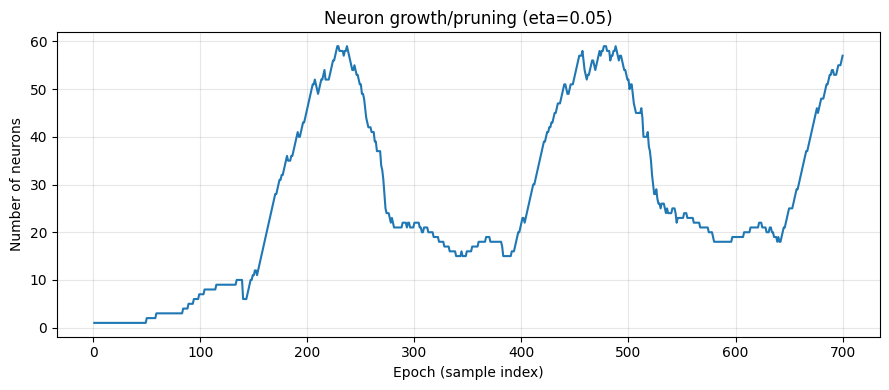

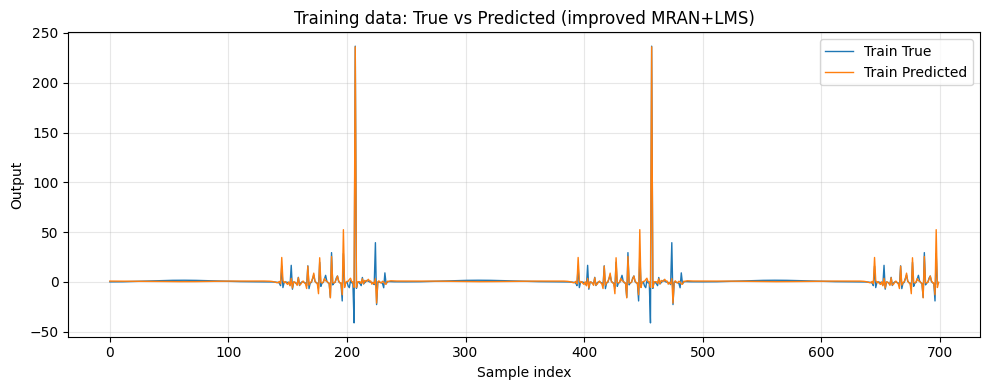

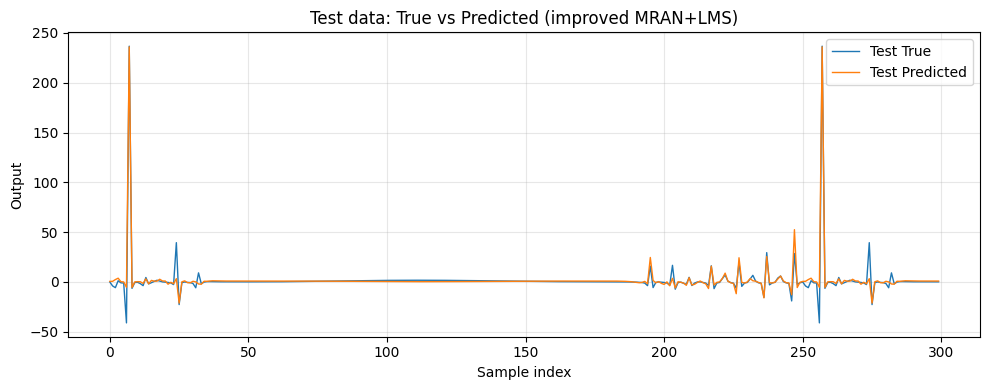

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ------------ Utilities ------------

def rbf_activity(x, centers, sigmas):
    """phi_k(x) for all centers."""
    if len(centers) == 0:
        return np.array([])
    centers = np.asarray(centers)
    sigmas = np.asarray(sigmas)
    diff = centers - x  # (K, d)
    dist2 = np.sum(diff**2, axis=1)
    return np.exp(-dist2 / (sigmas**2 + 1e-12))


def update_sigmas_from_centers(centers, k_overlap=0.8, default_sigma=1.0):
    """sigma_k = k_overlap * distance_to_nearest_other_center."""
    centers = np.asarray(centers)
    K = centers.shape[0]
    if K == 1:
        return np.array([default_sigma], dtype=float)
    sigmas = np.zeros(K)
    for i in range(K):
        diff = centers[i] - centers
        dist = np.linalg.norm(diff, axis=1)
        dist[i] = np.inf
        d_min = np.min(dist)
        sigmas[i] = k_overlap * d_min
    return sigmas


def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))


# ------------ Improved MRAN + LMS (with predictions) ------------

def train_mran_lms_improved(
    X_train, y_train, X_test, y_test,
    e_min=0.125,
    eps=0.25,
    k_overlap=0.8,
    eta=0.05,
    # growth extra:
    rms_window=50,
    e_rms_min=0.2,
    # pruning hyperparams:
    delta=0.02,
    M_inactive=40,
    warmup_samples=100,
    min_age=50,
    min_neurons=5,
):
    """
    Adaptive RBF with:
      - Growth: (|e| > e_min) & (dist > eps) & (e_rms > e_rms_min)
      - LMS on output weights
      - Participation-based pruning with age & warm-up

    Returns:
      train_rmse, test_rmse, final_num_neurons,
      neuron_history, centers_arr, sigmas, alpha,
      y_train_pred, y_test_pred
    """

    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    X_test  = np.asarray(X_test)
    y_test  = np.asarray(y_test)

    N_train, d = X_train.shape

    centers = []
    sigmas = np.array([])
    alpha = np.array([])
    inactive_count = np.array([], dtype=int)
    age = np.array([], dtype=int)

    neuron_history = []
    error_buffer = []   # for sliding RMS

    for n in range(N_train):
        x_n = X_train[n]
        y_n = y_train[n]

        # --- First sample: initialize first neuron ---
        if len(centers) == 0:
            centers.append(x_n.copy())
            centers_arr = np.array(centers)
            sigmas = update_sigmas_from_centers(
                centers_arr, k_overlap=k_overlap, default_sigma=1.0
            )
            alpha = np.array([0.0])   # will be updated by LMS
            inactive_count = np.zeros(1, dtype=int)
            age = np.zeros(1, dtype=int)
            neuron_history.append(1)
            error_buffer.append(float(y_n))  # arbitrary, not used yet
            continue

        centers_arr = np.array(centers)
        K = centers_arr.shape[0]

        # ensure shapes
        if sigmas.shape[0] != K:
            sigmas = update_sigmas_from_centers(
                centers_arr, k_overlap=k_overlap, default_sigma=1.0
            )
        if alpha.shape[0] != K:
            alpha = np.resize(alpha, K)
        if inactive_count.shape[0] != K:
            inactive_count = np.resize(inactive_count, K)
            inactive_count[:] = 0
        if age.shape[0] != K:
            age = np.resize(age, K)

        # --- Forward & error ---
        phi_n = rbf_activity(x_n, centers_arr, sigmas)  # (K,)
        y_hat_n = float(np.dot(alpha, phi_n))
        e_n = y_n - y_hat_n

        # update error buffer and compute sliding RMS
        error_buffer.append(float(e_n))
        if len(error_buffer) > rms_window:
            error_buffer.pop(0)
        if len(error_buffer) == rms_window:
            e_rms = np.sqrt(np.mean(np.array(error_buffer) ** 2))
        else:
            e_rms = 0.0  # not enough samples yet

        # --- Growth rule: |e| > e_min, dist > eps, e_rms > e_rms_min ---
        dists = np.linalg.norm(centers_arr - x_n, axis=1)
        min_dist = float(np.min(dists))

        grow = False
        if (abs(e_n) > e_min) and (min_dist > eps) and (e_rms > e_rms_min):
            grow = True

        if grow:
            # new center at x_n
            centers.append(x_n.copy())
            centers_arr = np.array(centers)
            # update sigmas using k_overlap
            sigmas = update_sigmas_from_centers(
                centers_arr, k_overlap=k_overlap, default_sigma=1.0
            )
            # new weight initialized to current error
            alpha = np.concatenate([alpha, np.array([e_n])])
            # init pruning stats for new neuron
            inactive_count = np.concatenate(
                [inactive_count, np.array([0], dtype=int)]
            )
            age = np.concatenate([age, np.array([0], dtype=int)])
            # recompute phi_n with new center included
            phi_n = rbf_activity(x_n, centers_arr, sigmas)
            y_hat_n = float(np.dot(alpha, phi_n))
            e_n = y_n - y_hat_n

        # --- LMS update on alpha ---
        alpha = alpha + eta * e_n * phi_n

        # --- Update ages ---
        age += 1  # every neuron gets older by one sample

        # --- Participation & pruning (after warmup) ---
        if n >= warmup_samples and len(centers) > 0:
            o_n = alpha * phi_n
            max_o = np.max(np.abs(o_n))
            if max_o > 0:
                r_n = np.abs(o_n) / max_o
            else:
                r_n = np.zeros_like(o_n)

            # low participation?
            low_part = r_n < delta
            inactive_count[low_part] += 1
            inactive_count[~low_part] = 0

            # decide which neurons to keep
            to_keep = np.ones(len(centers), dtype=bool)
            for k in range(len(centers)):
                if (
                    age[k] >= min_age and
                    inactive_count[k] >= M_inactive and
                    len(centers) > min_neurons
                ):
                    to_keep[k] = False

            if not np.all(to_keep):
                centers_arr = centers_arr[to_keep]
                sigmas = sigmas[to_keep]
                alpha = alpha[to_keep]
                inactive_count = inactive_count[to_keep]
                age = age[to_keep]
                centers = [c for c, keep in zip(centers, to_keep) if keep]

        neuron_history.append(len(centers))

    # --- Final evaluation and predictions ---
    centers_arr = np.array(centers)
    K = centers_arr.shape[0]

    if K == 0:
        # degenerate
        return 1e9, 1e9, 0, neuron_history, None, None, None, None, None

    Phi_train = np.vstack([rbf_activity(x, centers_arr, sigmas) for x in X_train])
    Phi_test  = np.vstack([rbf_activity(x, centers_arr, sigmas) for x in X_test])

    y_train_pred = Phi_train @ alpha
    y_test_pred  = Phi_test  @ alpha

    train_rmse = rmse(y_train, y_train_pred)
    test_rmse  = rmse(y_test,  y_test_pred)

    return (
        train_rmse,
        test_rmse,
        K,
        neuron_history,
        centers_arr,
        sigmas,
        alpha,
        y_train_pred,
        y_test_pred,
    )


# --------- Run with your fixed hyperparams and plot ---------

eta = 0.05

(
    tr_rmse,
    te_rmse,
    n_centers,
    neuron_hist,
    centers_arr,
    sigmas,
    alpha,
    y_train_pred,
    y_test_pred,
) = train_mran_lms_improved(
    X_train, y_train, X_test, y_test,
    e_min=0.125,
    eps=0.25,
    k_overlap=0.8,
    eta=eta,
    rms_window=50,
    e_rms_min=0.2,
    delta=0.02,
    M_inactive=40,
    warmup_samples=100,
    min_age=50,
    min_neurons=5,
)

print(f"Improved MRAN+LMS (eta={eta})")
print(f"Train RMSE = {tr_rmse:.4f}")
print(f"Test  RMSE = {te_rmse:.4f}")
print(f"Final number of neurons = {n_centers}")

# neuron-count curve (مثل قبل، اگر لازم داری)
epochs = np.arange(1, len(neuron_hist)+1)
plt.figure(figsize=(9,4))
plt.plot(epochs, neuron_hist)
plt.xlabel("Epoch (sample index)")
plt.ylabel("Number of neurons")
plt.title(f"Neuron growth/pruning (eta={eta})")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot: Train True vs Predicted ---

plt.figure(figsize=(10,4))
plt.plot(y_train, label="Train True", linewidth=1)
plt.plot(y_train_pred, label="Train Predicted", linewidth=1)
plt.title("Training data: True vs Predicted (improved MRAN+LMS)")
plt.xlabel("Sample index")
plt.ylabel("Output")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot: Test True vs Predicted ---

plt.figure(figsize=(10,4))
plt.plot(y_test, label="Test True", linewidth=1)
plt.plot(y_test_pred, label="Test Predicted", linewidth=1)
plt.title("Test data: True vs Predicted (improved MRAN+LMS)")
plt.xlabel("Sample index")
plt.ylabel("Output")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
